<a href="https://colab.research.google.com/github/Oreolorun/Image-Recognition/blob/main/CarTypeImageRegcognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#  importing libraries 
import os
import numpy as np
import torch
from torchvision import transforms
from torchvision import models
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
from tqdm import tqdm
from tqdm.notebook import tqdm as tqdm_notebook
import matplotlib.pyplot as plt
import cv2
import seaborn as sns

In [2]:
#  mounting drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
#  configuring device
if torch.cuda.is_available():
  device = torch.device('cuda:0')
  print('Running on the GPU')
else:
  device = torch.device('cpu')
  print('Running on the CPU')

Running on the GPU


In [4]:
#  loading and labelling data

class LoadVehicleData():
  def __init__(self):
    self.sedans = 'gdrive/My Drive/Datasets/Car_Images/sedans'
    self.coupes = 'gdrive/My Drive/Datasets/Car_Images/coupes'
    self.suvs = 'gdrive/My Drive/Datasets/Car_Images/suvs'
    self.trucks = 'gdrive/My Drive/Datasets/Car_Images/trucks'
    self.labels = {self.sedans:0, self.coupes:1, self.suvs:2, self.trucks:3}
    self.img_size = 75
    self.training_data = []
    self.sedan_count = 0
    self.coupe_count = 0
    self.suv_count = 0
    self.truck_count = 0

  def create_dataset(self):
    for key in self.labels:
      print(key)
      for img_file in tqdm(os.listdir(key)):
        try:
          path = os.path.join(key, img_file)
          image = cv2.imread(path)
          image = cv2.resize(image, (self.img_size, self.img_size))
          image = np.array(image)
          self.training_data.append([image, int(self.labels[key])])
          if key == self.sedans:
            self.sedan_count+=1
          elif key == self.coupes:
            self.coupe_count+=1
          elif key == self.suvs:
            self.suv_count+=1
          elif key == self.trucks:
            self.truck_count+=1
        except Exception as e:
          pass
    np.random.shuffle(self.training_data)
    np.save('completely_loaded.npy', self.training_data)
    print(f'\nsedan images: {self.sedan_count}')
    print(f'coupe images: {self.coupe_count}')
    print(f'suv images: {self.suv_count}')
    print(f'truck images: {self.truck_count}')
    print(f'total: {self.sedan_count + self.coupe_count + self.suv_count + self.truck_count}')
    print('All done!')

In [5]:
#  creating an instance of the class LoadVehicleData
data = LoadVehicleData()

#  creating dataset
data.create_dataset()

#  loading dataset into object
dataset = np.load('completely_loaded.npy', allow_pickle=True)

gdrive/My Drive/Datasets/Car_Images/sedans


100%|██████████| 14324/14324 [04:59<00:00, 47.82it/s] 


gdrive/My Drive/Datasets/Car_Images/coupes


100%|██████████| 14488/14488 [04:22<00:00, 55.09it/s] 


gdrive/My Drive/Datasets/Car_Images/suvs


100%|██████████| 14560/14560 [04:35<00:00, 52.90it/s] 


gdrive/My Drive/Datasets/Car_Images/trucks


100%|██████████| 14448/14448 [04:39<00:00, 51.62it/s] 
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)



sedan images: 14322
coupe images: 14488
suv images: 14560
truck images: 14445
total: 57815
All done!


In [6]:
#  checking dataset
len(dataset)

57815

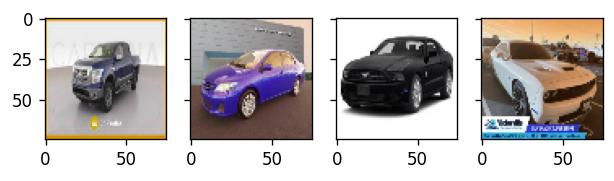

In [7]:
#  Displaying random images
figure, axes = plt.subplots(1,4, dpi=120, sharey=True)
axes[0].imshow(dataset[2457][0])
axes[1].imshow(dataset[1][0])
axes[2].imshow(dataset[23967][0])
axes[3].imshow(dataset[19929][0])

In [8]:
#  defining splitting function
def train_val_split(dataset_to_split, val_pct):
  #  deriving dataset length
  number_of_instances = len(dataset_to_split)
  #  deriving length of validattion set
  val_idx = int(number_of_instances*val_pct)
  #  deriving random permutations of the whole dataset
  idx = list(np.random.permutation(number_of_instances))
  return idx[:val_idx], idx[val_idx:]

#  creating testing, validation and training indices
test_indices, dataset_indices = train_val_split(dataset, 0.1)
val_indices, train_indices = train_val_split(dataset_indices, 0.2)

#  splitting into training, validation and test sets
training_set = dataset[train_indices]
validation_set = dataset[val_indices]
test_set = dataset[test_indices]

In [9]:
#  extending Dataset class
class VehicleDataset(Dataset):
  def __init__(self, loaded_dataset, transforms=None):
    self.loaded_dataset = loaded_dataset
    self.transforms = transforms

  def __len__(self):
    return len(self.loaded_dataset)
  
  def __getitem__(self, idx):
    #  extracting image from index and scaling
    image = self.loaded_dataset[idx][0]/255
    #  extracting label from index
    label = torch.tensor(int(self.loaded_dataset[idx][1]))
    #  applying transforms if transforms are supplied
    if self.transforms:
      image = self.transforms(image)
    return (image, label)

In [27]:
#  creating an instances of the dataset class
train_ds = VehicleDataset(training_set, transforms=transforms.ToTensor())
val_ds = VehicleDataset(validation_set, transforms=transforms.ToTensor())
test_ds = VehicleDataset(test_set, transforms=transforms.ToTensor())

#  creating dataloaders
train_dl = DataLoader(train_ds, batch_size=400, shuffle=True) 
val_dl = DataLoader(val_ds, batch_size=400, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=400, shuffle=True)

In [37]:
#  building neural network
class CarRecognition(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 32, 3)
    self.conv2 = nn.Conv2d(32, 32, 3)
    self.conv3 = nn.Conv2d(32, 64, 3)
    self.conv4 = nn.Conv2d(64, 64, 3)
    self.conv5 = nn.Conv2d(64, 128, 3)
    self.conv6 = nn.Conv2d(128, 128 ,3)
    self.conv7 = nn.Conv2d(128, 128, 3)
    self.fc1 = nn.Linear(2048, 514)
    self.fc2 = nn.Linear(514, 128)
    self.fc3 = nn.Linear(128, 4)
    self.pool = nn.MaxPool2d(2,2)

  def forward(self, x):
    x = x.view(-1, 3, 75, 75).float()
    x = F.relu(self.conv1(x))
    x = self.pool(F.relu(self.conv2(x)))
    x = F.relu(self.conv3(x))
    x = self.pool(F.relu(self.conv4(x)))
    x = F.relu(self.conv5(x))
    x = F.relu(self.conv6(x))
    x = self.pool(F.relu(self.conv7(x)))
    x = torch.flatten(x,1)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.relu(self.fc3(x))
    return F.log_softmax(x, dim=1)

In [29]:
class CarRecognition_test(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 32, 3)
    self.conv2 = nn.Conv2d(32, 64, 3)
    self.conv3 = nn.Conv2d(64, 128, 3)
    self.fc1 = nn.Linear(6272, 514)
    self.fc2 = nn.Linear(514, 128)
    self.fc3 = nn.Linear(128, 4)
    self.pool = nn.MaxPool2d(2,2)

  def forward(self, x):
    x = x.view(-1, 3, 75, 75).float()
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = self.pool(F.relu(self.conv3(x)))
    x = torch.flatten(x,1)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.relu(self.fc3(x))
    return F.log_softmax(x, dim=1)

In [13]:
def accuracy(network, train_loader, verbose=False):
  #  creating counter for correctly classified instances
  correctly_classified = 0
  #  creating counter for all instances
  all_instances = 0
  #  looping through every batch
  for images, labels in tqdm_notebook(train_loader):
    images, labels = images.to(device), labels.to(device)
    #  classifying
    outputs = network(images)
    #  deriving the index of model prediction
    predicted_labels = torch.argmax(outputs, dim=1)
    #  comparing and counting the number of correct predictions
    correct_labels = sum(predicted_labels==labels)
    #  counting correct predictions
    correctly_classified+=correct_labels.item()
    #  counting all instances
    all_instances+=len(labels)
  if verbose:
    return print(f'model predicts all instances to {(correctly_classified/all_instances)*100}% accuracy')
  else:
    return correctly_classified/all_instances

In [14]:
def train_model(network, epochs, loss_function, opt, train_loader, val_loader):
  #  creating a list to hold metrics
  metric_log = []
  for epoch in range(epochs):
    print(f'\nTraining Epoch {epoch+1}/{epochs}')
    total_loss = 0
    for images, labels in tqdm_notebook(train_loader):
      #  sending to device
      images, labels = images.to(device), labels.to(device)
      #  resetting gradients
      opt.zero_grad()
      #  classifying
      outputs = network(images)
      #  computing loss
      loss = loss_function(outputs, labels)
      #  summing loss
      total_loss+=loss.sum().item()
      #  computing gradients
      loss.backward()
      #  optimizing
      opt.step()
    #  deriving training accuracy
    with torch.no_grad():
      print('Deriving training accuracy...')
      train_accuracy = accuracy(network, train_loader)
    #  deriving validation loss and accuracy
    with torch.no_grad():
      print('Deriving validation loss...')
      total_val_loss = 0
      for val_images, val_labels in tqdm_notebook(val_loader):
        #  sending to device
        val_images, val_labels = val_images.to(device), val_labels.to(device)
        #  classifying
        val_outputs = network(val_images)
        #  computing loss
        val_loss = loss_function(val_outputs, val_labels)
        #  suming val_loss
        total_val_loss+=val_loss.sum().item()
      print('Deriving validation accuracy...')
      #  computing accuracy
      val_accuracy = accuracy(network, val_loader)
    #  appending metrics to list
    metric_log.append([epoch+1, total_loss, train_accuracy, total_val_loss, val_accuracy])
    #  displaying results
    print(f'Epoch: {epoch+1}/{epochs} Training_loss: {round(total_loss, 5)} Training_accuracy: {round(train_accuracy, 5)} Validation_loss: {round(total_val_loss, 5)} Validation_accuracy: {round(val_accuracy, 5)}')
  np.save('metrics_log_custom_model.npy', metric_log)
  np.savetxt(f'gdrive/My Drive/Neural Networks/Model_Metric_Logs/car_rec_model_{str(1)}.csv', np.array(metric_log))

In [15]:
def train_model_dup(network, epochs, loss_function, opt, train_loader):
  #  creating a list to hold metrics
  metric_log = []
  for epoch in range(epochs):
    print(f'\nTraining Epoch {epoch+1}/{epochs}')
    total_loss = 0
    for images, labels in tqdm_notebook(train_loader):
      #  sending to device
      images, labels = images.to(device), labels.to(device)
      #  classifying
      outputs = network(images)
      #  computing loss
      loss = loss_function(outputs, labels)
      #  summing loss
      total_loss+=loss.sum().item()
      #  computing gradients
      loss.backward()
      #  optimizing
      opt.step()
      opt.zero_grad()
    #  deriving training accuracy
    print('Deriving training accuracy...')
    train_accuracy = accuracy(network, train_loader)
    #  displaying results
    print(f'Epoch: {epoch+1}/{epochs} Training_loss: {round(total_loss, 5)} Training_accuracy: {round(train_accuracy, 5)}')

In [17]:
for train_batch in train_dl:
  print(len(train_batch))
  break

2


In [18]:
for val_batch in val_dl:
  print(len(val_batch))
  break

2


In [19]:
train_batch = [train_batch]
val_batch = [val_batch]

In [ ]:
model = CarRecognition()
model.to(device)

model_sample = CarRecognition_test()
model_sample.to(device)

loss_fn = nn.NLLLoss()

optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
epochs = 10

train_model(network=model, epochs=epochs, loss_function=loss_fn, 
            opt=optimizer, train_loader=train_dl, val_loader=val_dl)

In [54]:
#  saving model state
torch.save(model.state_dict(), f'gdrive/My Drive/Neural Networks/Model_States/car_recognition_model_state_{str(1)}.pt')

In [69]:
#  loading metric log
metrics_log = np.load('metrics_log_custom_model.npy', allow_pickle=True)

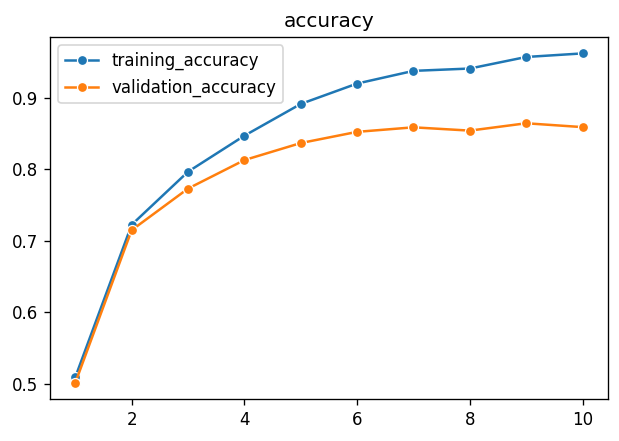

In [73]:
#  visualising metrics
figure, axes = plt.subplots(2,1, dpi=120, sharex=True)
axes[0,0].set_title('accuracy vs epoch')
axes[0,0].ylabel('accuracy')
axes[1,0].set_title('loss vs epoch')
axes[1,0].ylabel('loss')
axes[1,0].xlabel('epoch')

sns.lineplot(x=metrics_log[:,0], y=metric_log[:,2], marker='o', label='training_accuracy', ax=axes[0,0])
sns.lineplot(x=metrics_log[:,0], y=metric_log[:,4], marker='o', label='validation_accuracy', ax=axes[0,0])

sns.lineplot(x=metrics_log[:,0], y=metric_log[:,1], marker='o', label='training_loss', ax=axes[1,0])
sns.lineplot(x=metrics_log[:,0], y=metric_log[:,3], marker='o', label='validation_loss', ax=axes[1,0])

In [ ]:
#  deriving test accuracy
accuracy(model, test_dl, verbose=True)

In [ ]:
def extract_results(network, dataloader):
  #  creating an empty list
  results = []
  labels = []
  #  classification
  with torch.no_grad():
    for img, lb in tqdm(dataloader):
      preds = network(img)
      results.extend(preds.tolist())
      labels.extend(lb.tolist())
  df = pd.DataFrame({'predicted': results, 'labels': labels})
  return df

In [ ]:
#  extracting test results
extraxt_results(model, test_dl)

In [56]:
for img, lb in test_dl:
  print(img.shape)
  print(lb)
  break

torch.Size([100, 3, 75, 75])
tensor([0, 0, 3, 3, 3, 1, 0, 1, 3, 3, 3, 0, 1, 0, 2, 1, 3, 0, 1, 3, 0, 0, 2, 3,
        0, 1, 2, 2, 3, 0, 2, 0, 3, 2, 3, 0, 0, 1, 0, 3, 2, 2, 2, 0, 0, 2, 1, 1,
        3, 2, 0, 2, 1, 2, 2, 0, 3, 1, 0, 0, 0, 1, 1, 2, 0, 0, 1, 2, 3, 0, 3, 0,
        0, 1, 2, 0, 3, 0, 0, 0, 0, 0, 1, 0, 3, 0, 0, 1, 2, 3, 3, 0, 0, 0, 1, 1,
        2, 2, 2, 2])


In [63]:
sum(torch.argmax(model(img.to(device)), dim=1)==lb.to(device))

tensor(93, device='cuda:0')

In [99]:
spam = [[1,2,3,4], [1,4,6,7]]
np.savetxt('example.csv', np.array(spam), delimiter=',')

In [102]:
import pandas as pd
pd.read_csv('example.csv', header=None)

,0,1,2,3
0,1.0,2.0,3.0,4.0
1,1.0,4.0,6.0,7.0


In [ ]:
#model = models.resnet50()
#model.to(device)